## Canny 边缘检测
1. 高斯滤波
2. 计算梯度
    - 使用 Sobel 算子计算每个像素点的水平和垂直梯度
    - 计算梯度的大小和方向
3. 非极大值抑制
    - 仅保留梯度方向上的局部最大值
4. 双阈值检测
    - 定义高低阈值
    - 判断像素点是否为强边缘、弱边缘、非边缘

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np

(512, 512)


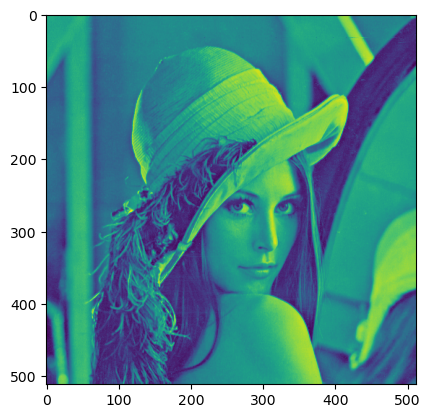

In [2]:
img = plt.imread('../lenna.png')
img = img * 255 # 0-1 to 0-255
img = img.mean(axis=-1) # RGB to grayscale
print(img.shape)
plt.imshow(img)

### 1. 高斯滤波
高斯滤波是一种线性平滑滤波器，可以有效的去除图像中的高斯噪声。高斯滤波器的卷积核是一个二维的高斯函数，可以通过下面的公式计算：

$$G(x, y) = \frac{1}{2\pi\sigma^2}\exp(-\frac{x^2+y^2}{2\sigma^2})$$

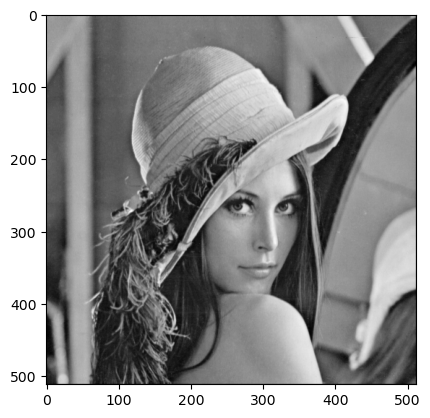

In [3]:
sigma = 0.5 # standard deviation
size = 5 # kernel size
kernel = np.zeros((size, size)) # initialize kernel
tmp = [i-size//2 for i in range(size)] # [-2, -1, 0, 1, 2], means the distance from the center
n1 = 1 / (2 * math.pi * sigma**2) # parf of the gaussian function
n2 = 2 * sigma**2 


for i in range(size):
    for j in range(size):
        kernel[i, j] = n1 * math.exp(-(tmp[i]**2 + tmp[j]**2) / n2) # gaussian function

kernel = kernel / kernel.sum() # normalization

new_img = np.zeros_like(img) # initialize new image

# padding; keeping the original size
padding_size = size // 2
img_padded = np.pad(img, ((padding_size, padding_size), (padding_size, padding_size)), 'constant') 

img_h, img_w = img.shape
for i in range(img_h):
    for j in range(img_w):
        new_img[i, j] = np.sum((img_padded[i:i+size, j:j+size] * kernel)) # convolution

plt.imshow(new_img, cmap='gray')


### 2. 使用 Sobel 算子计算梯度

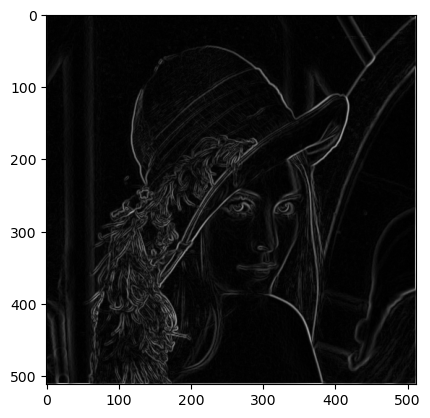

In [4]:
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) # sobel kernel for x
sobel_kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # sobel kernel for y
gradient_x = np.zeros_like(img) # initialize gradient x
gradient_y = np.zeros_like(img) # initialize gradient y
img_grad = np.zeros_like(img) # initialize gradient magnitude

img_padded = np.pad(new_img, ((1, 1), (1, 1)), 'constant') # padding
for i in range(img_h):
    for j in range(img_w):
        gradient_x[i, j] = np.sum((img_padded[i:i+3, j:j+3] * sobel_kernel_x))
        gradient_y[i, j] = np.sum((img_padded[i:i+3, j:j+3] * sobel_kernel_y))
        img_grad[i, j] = math.sqrt(gradient_x[i, j]**2 + gradient_y[i, j]**2) # gradient magnitude

gradient_x[gradient_x == 0] = 1e-6 # avoid division by zero
gradient_direction = gradient_y / gradient_x # gradient direction
plt.imshow(img_grad, cmap='gray')


### 3. 非极大值抑制
非极大值抑制是一种边缘稀疏技术，可以帮助我们找到图像中的局部最大值。在 Canny 边缘检测中，我们需要保留梯度方向上的局部最大值，而抑制非极大值。

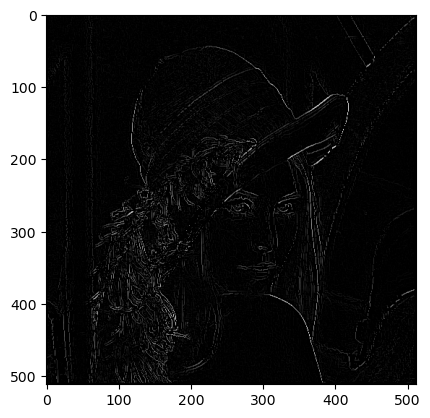

In [5]:
img_suppressed = np.zeros_like(img_grad) # initialize non-maximum suppressed image
# using bilinear interpolation to get the gradient values at the four points around the pixel
for i in range(1, img_h-1):
    for j in range(1, img_w-1):
        temp_matrix = img_grad[i-1:i+2, j-1:j+2]
        angle = gradient_direction[i, j]
        if (angle <= -1):
            num1 = (temp_matrix[0, 1] - temp_matrix[0, 0]) / angle + temp_matrix[0, 0]
            num2 = (temp_matrix[2, 1] - temp_matrix[2, 2]) / angle + temp_matrix[2, 2]
        elif (angle >= 1):
            num1 = (temp_matrix[0, 1] - temp_matrix[0, 2]) / angle + temp_matrix[0, 2]
            num2 = (temp_matrix[2, 1] - temp_matrix[2, 0]) / angle + temp_matrix[2, 0]
        elif (angle > 0):
            num1 = (temp_matrix[1, 0] - temp_matrix[0, 0]) * angle + temp_matrix[0, 0]
            num2 = (temp_matrix[1, 2] - temp_matrix[2, 2]) * angle + temp_matrix[2, 2]
        elif (angle < 0):
            num1 = (temp_matrix[1, 0] - temp_matrix[2, 0]) * angle + temp_matrix[2, 0]
            num2 = (temp_matrix[1, 2] - temp_matrix[0, 2]) * angle + temp_matrix[0, 2]
        
        if (temp_matrix[1, 1] >= num1 and temp_matrix[1, 1] >= num2):
            img_suppressed[i, j] = img_grad[i, j]

plt.imshow(img_suppressed, cmap='gray')
plt.show()

### 4. 双阈值检测
双阈值检测是 Canny 边缘检测的最后一步，我们需要定义两个阈值：高阈值和低阈值。如果像素点的梯度值大于高阈值，我们将其标记为强边缘；如果像素点的梯度值小于低阈值，我们将其标记为非边缘；如果像素点的梯度值在两个阈值之间，我们将其标记为弱边缘。

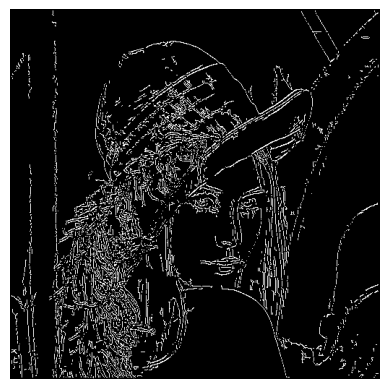

In [13]:
from collections import deque
low_threshold = img_grad.mean() * 0.5
high_threshold = low_threshold * 3

processed = set()
queue = deque()
offsets = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]

for i in range(1, img_h-1):
    for j in range(1, img_w-1):
        if img_suppressed[i, j] > high_threshold:
            img_suppressed[i, j] = 255
            queue.append((i, j))
            processed.add((i, j))
        elif img_suppressed[i, j] <= low_threshold:
            img_suppressed[i, j] = 0

while queue:
    i, j = queue.popleft()
    for offset in offsets:
        new_i = i + offset[0]
        new_j = j +  offset[1]

        if (new_i, new_j) in processed:
            continue
        value = img_suppressed[new_i, new_j]
        if value > low_threshold and value < high_threshold:
            img_suppressed[new_i, new_j] = 255
            queue.append((new_i, new_j))
            processed.add((new_i, new_j))

img_suppressed[(img_suppressed != 255) & (img_suppressed != 0)] = 0

plt.imshow(img_suppressed, cmap='gray')
plt.axis('off')
plt.show()
